<a href="https://colab.research.google.com/github/hydanggia/woundhealingproject/blob/master/TestMethodHeatEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import numpy as np
def u_exact(x, y,t):
        return math.sin(x)*math.sin(y)*math.e**((-2)*t)  # fulfills BC at x=0 and x=L
def I(x,y):
        return u_exact(x,y,0)
def bc(x,y,t):
        return u_exact(x,y,t)
def f(x,y):
        return math.sin(x)*math.sin(y)


In [0]:
import math
import numpy as np
#exact solution.
def exactsol(Nx,Ny,T):
  x = np.linspace(0, math.pi, Nx+1)       # Mesh points in space
  y = np.linspace(0, math.pi, Nx+1) 
  u_n = np.zeros((Nx+1,Nx+1))
  for j in range(0,Nx):
      for k in range(0, Ny):
          u_n[j,k] = u_exact(x[j],y[k],T)
  return u_n

In [0]:
def Eulersolver(I,L, dt,dx,dy, T):
    #Parameters: 
    #L is the end interval of x 
    #Nt, Nx are the number of mesh points in time and in x
    #T the stop time for simulation.
    #I (the initial condition of u(0,x) = f(x))
    #
    """
    Simplest expression of the computational algorithm
    using the Forward Euler method and explicit Python loops.
    For this method F <= 0.5 for stability.
    """
    
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    Nx = int(round(L/dx))
    Ny = int(round(L/dy))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    y = np.linspace(0, L, Ny+1) 
    # Make sure dx and dt are compatible with x and t
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    X, Y = np.meshgrid(x, y)
    u   = np.zeros((Nx+1,Ny+1))
    u_n = np.zeros((Nx+1,Ny+1))
    # Set initial condition u(x,0) = I(x)
    for i in range(0,Nx+1):
      for j in range(0, Ny+1):
        u_n[i,j] = I(x[i],y[j])
    for n in range(1, Nt):
        # Compute u at inner mesh points
        for i in range(1, Nx):
          for j in range(1,Ny):
            u[i,j] = u_n[i,j] + (dt/(dx**2))*(u_n[i-1,j] - 2*u_n[i,j] + u_n[i+1,j]) + \
             (dt/(dy**2))*(u_n[i,j-1] - 2*u_n[i,j] + u_n[i,j+1])
        u_n = u.copy()
    return u,Nx,Ny,Nt,X,Y  # u_n holds latest u



In [0]:
import numpy as np
from scipy import linalg
def solver_ADI(I,f,bc,Lx,Ly,Nx,Ny,dt,T):
  dx = Lx/float(Nx)
  dy = Ly/float(Ny)
  x = np.linspace(0,Lx,Nx+1) #Create points in direction of x
  y = np.linspace(0,Ly,Ny+1) #Create points in direction of y
  u = np.zeros((Nx+1,Ny+1),float) #Create Solution Array.
  u_half = u.copy() #Create a solution at t + dt/2
  u_last = u.copy() #Create a solution at t + dt

  C_x = dt/dx**2 #Constant for equation in x part
  C_y = dt/dy**2 #Constant for equation in y part

  #Set initial condition: 
  t = 0.0
  for i in range(0,Nx+1):
    for j in range(0,Ny+1): 
      u[i,j] = I(x[i],y[j])

  while t<= T:        #Create t<=T
    t_last = t        #Set t_last = last t
    t +=0.5*dt        #Set new t = t + 1/2dt
    #Sweep in x direction
    j = 0 #left boundary
    for i in range(0,Nx+1):
      u_half[i,j] = bc(x[i],y[j],t)
    #Solve tridiagonal system for internal columns j
    for j in range(0,Nx):
      A = np.zeros(shape = (Nx+1,Nx+1))
      b = np.zeros(Nx+1,float)
      #First treat lower boundary for col j
      i = 0
      A[i,i] = 1 #First in diagonal
      b[i] = bc(x[i],y[j],t)
      #Run through inner points for col j
      for i in range(1,Nx):
        A[i,i-1] = -C_x
        A[i,i] = 2 + 2*C_x
        A[i,i+1] = -C_x
        b[i] = 2*u[i,j] + C_y*(u[i,j-1] - 2*u[i,j]+u[i,j+1])
        #Second treat upper boundary
      i = Nx
      A[i,i] = 1
      b[i] = bc(x[i],y[j],t)
        #Solve system x = A^(-1) * b
      temp = linalg.solve(A,b)
        #Insert sol into col j
      for i in range(0,Nx+1):
        u_half[i,j] = temp[i]
    j = Ny #right boundary
    for i in range(0,Nx+1):
      u_half[i,j] = bc(x[i],y[j],t)
    t_last = t
    t +=0.5*dt
    # Sweep in y direction
    i = 0 #lower boundary
    for j in range(0,Ny+1):
      u_last[i,j] = bc(x[i],y[j],t)
    #Solve tridiagonal system for internal row i
    for i in range(1,Nx):
      B = np.zeros(shape = (Ny+1,Ny+1))
      c = np.zeros(Ny+1,float)
      #First treat left boundary for row i
      j = 0
      B[j,j] = 1 #First in diagonal
      c[j] = bc(x[i],y[j],t)
      #Run through inner points for col j
      for j in range(1,Ny):
        B[j,j-1] = -C_y
        B[j,j] = 2 + 2*C_y
        B[j,j+1] = -C_y
        c[j] = 2*u_half[i,j] + C_x*(u_half[i-1,j] - 2*u_half[i,j]+u_half[i+1,j]) 
        #Second treat right boundary
      j = Ny
      B[j,j] = 1
      c[j] = bc(x[i],y[j],t)
        #Solve system x = A^(-1) * b
      temp = linalg.solve(A,c)
        #Insert sol into col j
      for j in range(0,Ny+1):
        u_last[i,j] = temp[j]
    i = Nx
    for j in range(0,Ny+1):
      u_last[i,j] = bc(x[i],y[j],t)   
    u = u_last.copy()   
  return u


Text(0.5, 0.92, 'ADI Method Approximation')

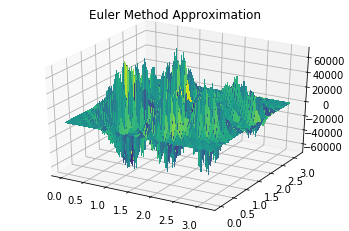

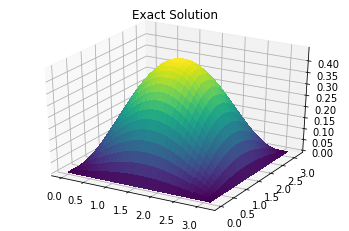

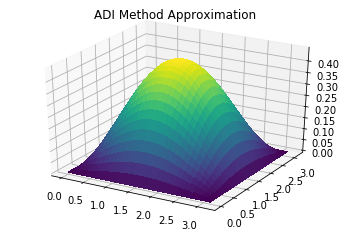

<Figure size 432x288 with 0 Axes>

In [0]:
#Parameter Inputs
L = math.pi
dt = 0.02
dx,dy = 0.1,0.1
T = .4
#Get the outputs of 2 functions
u,Nx,Ny,Nt,X,Y = Eulersolver(I,L,dt,dx,dy,T) #Euler Method
u_n = exactsol(Nx,Ny,T) #Exact Solution
u_ADI = solver_ADI(I,f,bc,L,L,Nx,Ny,dt,T)
#Plotting 2 Function
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D ##library for 3d projection plots
%matplotlib inline
fig = pyplot.figure()
ax = fig.gca(projection='3d')
#Euler Method
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_title("Euler Method Approximation")
fig = pyplot.figure()
ax = fig.gca(projection='3d')
#Exact Solution
surf = ax.plot_surface(X, Y, u_n, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_title("Exact Solution")                     
fig = pyplot.figure()
ax = fig.gca(projection='3d')
#ADI Solution
surf = ax.plot_surface(X, Y, u_ADI, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
fig = pyplot.figure()
ax.set_title("ADI Method Approximation")




In [0]:
np.sum(np.square(np.subtract(u_n,u)))

534119768257.6423

In [0]:
np.sum(np.square(np.subtract(u_n,u_ADI)))

2.1004910116576907e-05